https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy

In [223]:
import numpy as np
import struct
import matplotlib.pyplot as plt

def load_data():
    with open('samples/t10k-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, -1))
        data=data/255
    with open('samples/t10k-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,)) # (Optional)
    return labels, data, nrows, ncols


In most contexts, including for machine learning, the convention is to stack these vectors as rows of the matrix, giving the matrix dimensions of $m : \text{rows} \times n : \text{columns}$, where $m$ is the number of training examples and $n$ is the number of features, in this case 784. To make our math easier, we're going to transpose this matrix, giving it dimensions $n \times m$ instead, with each column corresponding to a training example and each row a training feature.

In [224]:
labels, data, nrows, ncols=load_data()
n_samples=10000
# m:rows:examples, n:columns:features
print(labels.shape)
print(data.shape)

# We transpose it to make math easier
data=data.T[:,:n_samples]
labels=labels[:n_samples]
print(labels.shape)
print(data.shape)

(10000,)
(10000, 784)
(10000,)
(784, 10000)


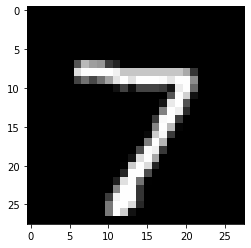

In [225]:
# Preview of first data point
plt.imshow(data[:,0].reshape(nrows,ncols), cmap='gray')
plt.show()

### Representing weights and biases

Let's look at our neural network now. Between every two layers is a set of connections between every node in the previous layer and every node in the following one. That is, there is a weight $w_{i,j}$ for every $i$ in the number of nodes in the previous layer and every $j$ in the number of nodes in the following one.

It's natural, then, to represent our weights as a matrix of dimensions $n^{[l]}\times n^{[l-1]}$, where $n^{[l-1]}$ is the number of nodes in the previous layer and $n^{[l]}$ is the number of nodes in the following layer. Let's call this matrix $W^{[l]}$, corresponding to layer $l$ of our network. $W^{[1]}$, for example, will be a $10\times784$ matrix, taking us from the 784 nodes of the input layer to the 10 nodes of the first hidden layer. $W^{[2]}$ will have dimensions $10\times10$.

Biases are simply constant terms added to each node of the following layer, so we can represent it as a matrix with dimensions $n^{[l]}\times 1$. Let's call these matrices $b^{[l]}$, so that $b^{[1]}$ and $b^{[2]}$ both have dimensions $10\times1$.



In [226]:
def init_params():
    N_L1=100
    N_L2=10
    W1 = np.random.rand(N_L1, 784) - 0.5
    b1 = np.random.rand(N_L1, 1) - 0.5
    W2 = np.random.rand(N_L2, N_L1) - 0.5
    b2 = np.random.rand(N_L2, 1) - 0.5
    return W1, b1, W2, b2

W1, b1, W2, b2 =init_params()

### Forward propagation
With these representations in mind, we can now write the equations for forward propagation.

First, we'll compute the unactivated values of the nodes in the first hidden layer by applying $W^{[1]}$ and $b^{[1]}$ to our input layer. We'll call the output of this operation $Z^{[1]}$:

$Z^{[1]} = W^{[1]}X+b^{[1]}$

Remember that $X$ has dimensions $784\times m$, and $W^{[1]} : 10\times784$. $W^{[1]}X$ is the dot product between the two, yielding a new matrix of dimensions $10\times m$. This may seem a little strange at first, but think of it this way: each column of this matrix corresponds to the unactivated values for the nodes in the first hidden layer when carried out for one training example, so the entire matrix represents carrying out the first step of forward propagation for all training examples at the same time. This is much more efficient than a for loop, and is what was referred to earlier as a "vectorized implementation."

Our bias term $b^{[1]}$has dimensions $10\times1$, but we want the same column of biases to be applied to all $m$ columns of training examples, so $b^{[1]}$is effectively broadcast into a matrix of dimensions $10\times m$ when calculating $Z^{[1]}$, matching the dimensions of $W^{[1]}X$.

We need to do one more calculation before moving on to the next layer, though, and that's applying a non-linear activation to $Z^{[1]}$. What does this mean, and why do we have to do it?

Imagine that we didn't do anything to $Z^{[1]}$ now, and multiplied it by $W^{[2]}$ and added $b^{[2]}$ to get the value for the next layer. $Z^{[1]}$ is a linear combination of the input features, and the second layer would be a linear combination of $Z^{[1]}$, making it still a linear combination of the input features. That means that our hidden layer is essentially useless, and we're just building a linear regression model.

To prevent this reduction and actually add complexity with our layers, we'll run $Z^{[1]}$ through a non-linear activation function before passing it off to the next layer. In this case, we'll be using a function called a rectified linear unit, or ReLU:



ReLU is a really simple function: it's linear if the input value is above 0, and outputs 0 otherwise. Just this much, though, is enough to ensure that our model doesn't collapse to a linear one.

From $Z^{[1]}$, we'll calculate a value $A^{[1]}$ for the values of the nodes in the hidden layer of our neural network after applying our activation function to it:

$A^{[1]} = \text{ReLU}(Z^{[1]})$

More generally, you might see this written as $A^{[l]} = g(Z^{[l]})$, with $g$ referring to an arbitrary activation function that may be something other than ReLU.

Once we have $A^{[1]}$, we can proceed to calculating the values for our second layer, which is also our output layer. First, we calculate $Z^{[2]}$:

$Z^{[2]} = W^{[2]}A^{[1]}+b^{[2]}$

Then, we'll apply an activation function to $Z^{[2]}$ to get our final output.

If this second layer were just another hidden layer, with more hidden layers or an output layer after it, we would apply ReLU again. But since it's the output layer, we'll apply a special activation function called softmax:



Diagram by Bartosz Szabłowski on Towards Data Science

Softmax takes a column of data at a time, taking each element in the column and outputting the exponential of that element divided by the sum of the exponentials of each of the elements in the input column. The end result is a column of probabilities between 0 and 1.

The value of using softmax for our output layer is that we can read the output as probabilities for certain predictions. In the diagram above, for example, we might read the output as a prediction that the second class has a 90% probability of being the correct label, the third a 5% probability, the fourth a 1% probability, and so on.

Let's find our $A^{[2]}$:

$A^{[2]} = \text{softmax}(Z^{[2]})$

Softmax runs element-wise, so the dimensions of $Z^{[2]}$ are preserved at $10\times m$. We can read this output matrix as follows: value $A^{[2]}_{i, j}$ is the probability that example $j$ is an image of the digit $i$.

With that, we've run through the entire neural network, going from our input $X$ containing all of our training examples to an output matrix $A^{[2]}$ containing prediction probabilities for each example.

In [227]:
def ReLU(Z):
    return np.maximum(Z,0)

def ReLU_dev(Z):
    return 1*(Z>0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1,b1,W2,b2,X):
    Z1=W1.dot(X)+b1
    A1=ReLU(Z1)
    Z2=W2.dot(A1)+b2
    A2=softmax(Z2)
    return Z1,A1,Z2,A2

def get_predictions(A2):
    return np.argmax(A2,axis=0)

In [228]:
Z1,A1,Z2,A2=forward_prop(W1,b1,W2,b2,data)
A2.shape

(10, 10000)

In [229]:
def one_hot(y):
    yy=np.zeros((y.max()+1,y.size))
    yy[y,np.arange(y.size)]=1
    return yy
one_hot_y=one_hot(labels)
print(one_hot_y.shape)
print(labels[0],one_hot_y[:,0])

(10, 10000)
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [230]:
def cross_ent(y,y_hat): # true(onehotencoded), predicted
    return -np.log(y_hat.T[y.astype(bool).T])

ce=cross_ent(one_hot_y,A2)

print(ce.shape)
print(ce)

(10000,)
[ 4.8182264  15.38713656  4.67389282 ...  7.6392943  18.21206472
  0.35372098]


### Backward propagation
Now, we'll go the opposite way and calculate how to nudge our parameters to carry out gradient descent.

Mathematically, what we're actually computing is the derivative of the loss function with respect to each weight and bias parameter. For a softmax classifier, we'll use a cross-entropy loss function:

$J(\hat{y}, y) = -\sum_{i=0}^{c} y_i \log(\hat{y}_i)$

Here, $\hat{y}$ is our prediction vector. It might look like this:

$\begin{bmatrix} 0.01 \ 0.02 \ 0.05 \ 0.02 \ 0.80 \ 0.01 \ 0.01 \ 0.00 \ 0.01 \ 0.07 \ \end{bmatrix}$

$y$ is the one-hot encoding of the correct label for the training example. If the label for a training example is 4, for example, the one-hot encoding of $y$ would look like this:

$\begin{bmatrix} 0 \ 0 \ 0 \ 0 \ 1 \ 0 \ 0 \ 0 \ 0 \ 0 \ \end{bmatrix}$

Notice that in our sum $\sum_{i=0}^{c} y_i \log(\hat{y}_i)$, $y_i = 0$ for all $i$ except the correct label. The loss for a given example, then, is just the log of the probability given for the correct prediction. In our example above, $J(\hat{y}, y) = -\log(y_4) = -\log(0.80) \approx 0.097$. Notice that, the closer the prediction probability is to 1, the closer the loss is to 0. As the probability approaches 0, the loss approaches $+\infty$. By minimizing the cost function, we improve the accuracy of our model. We do so by substracting the derivative of the loss function with respect to each parameter from that parameter over many rounds of graident descent:

$W^{[1]} := W^{[1]} - \alpha \frac{\delta J}{\delta W^{[1]}} \ b^{[1]} := b^{[1]} - \alpha \frac{\delta J}{\delta b^{[1]}} \ W^{[2]} := W^{[2]} - \alpha \frac{\delta J}{\delta W^{[2]}} \ b^{[2]} := b^{[2]} - \alpha \frac{\delta J}{\delta b^{[2]}} \ $

Our objective in backprop is to find $\frac{\delta J}{\delta W^{[1]}},\frac{\delta J}{\delta b^{[1]}},\frac{\delta J}{\delta W^{[2]}},$ and $\frac{\delta J}{\delta b^{[2]}}$. For concision, we'll write these values as $dW^{[1]}, db^{[1]}, dW^{[2]},$ and $db^{[2]}$. We'll find these values by stepping backwards through our network, starting by calculating $\frac{\delta J}{\delta A^{[2]}}$, or $dA^{[2]}$. Turns out that this derivative is simply:

$dA^{[2]} = Y - A^{[2]}$

If you know calculus, you can take the derivative of the loss function and confirm this for yourself. (Hint: $\hat{y} = A^{[2]}$)

From $dA^{[2]}$, we can calculate $dW^{[2]}$ and $db^{[1]}$:

$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T} \ dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$

Then, to calculate $dW^{[1]}$ and $db^{[1]}$, we'll first find $dZ^{[1]}$:

$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (Z^{[1]})$

I won't explain all the details of the math, but you can get some intuitive hints at what's going on here by just looking at the variables. We're applying $W^{[2]T}$ to $dZ^{[2]}$, akin to applying the weights between layers 1 and 2 in reverse. Then, we perform an element-wise multiplication with the derivative of the activation function, akin to "undoing" it to get the correct error values.

Since our activation function is ReLU, our derivative is actually pretty simple. Let's revisit our graph:



When the input value is greater than 0, the activation function is linear with a derivative of 1. When the input value is less than 0, the activation function is horizontal with a derivative of 0. Thus, $g^{[1]\prime}(Z^{[1]})$ is just a matrix of 1s and 0s based on values of $Z^{[1]}$.

From here, we do the same calculations as earlier to find $dW^{[1]}$ and $db^{[1]}$, using $X$ in place of $A^{[1]}$:

$dW^{[1]} = \frac{1}{m} dZ^{[1]} X^T \ dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$

Now we've found all the derivatives we need, and all that's left is to update our parameters:

$W^{[2]} := W^{[2]} - \alpha dW^{[2]} \ b^{[2]} := b^{[2]} - \alpha db^{[2]} \ W^{[1]} := W^{[1]} - \alpha dW^{[1]} \ b^{[1]} := b^{[1]} - \alpha db^{[1]}$

Here, $\alpha$is our learning rate, a "hyperparameter" that we set to whatever we want. $\alpha$ is distinguished from other parameters because, just like the number of layers in the network or the number of units in each layer, it's a value that we choose for our model rather than one that gradient descent optimizes.

With that, we've gone over all the math that we need to carry out gradient descent and train our neural network. To recap: first, we carry out forward propagation, getting a prediction from an input image:

$Z^{[1]} = W^{[1]} X + b^{[1]}A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))\Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}A^{[2]} = g_{\text{softmax}}(Z^{[2]})$

Then, we carry out backprop to compute loss function derivatives:

$dZ^{[2]} = A^{[2]} - Y dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$

Finally, we update our parameters accordingly:

$W^{[2]} := W^{[2]} - \alpha dW^{[2]} \ b^{[2]} := b^{[2]} - \alpha db^{[2]} \ W^{[1]} := W^{[1]} - \alpha dW^{[1]} \ b^{[1]} := b^{[1]} - \alpha db^{[1]}$

We'll do this process over and over again — the exact number of times, an iteration count that we again set ourselves — until we are satisfied with the performance of our model.

https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy
![](d1.png)
![](d2.png)

In [231]:
# forward_prop(W1,b1,W2,b2,X):
# return Z1,A1,Z2,A2
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    N=labels.size
    one_hot_y=one_hot(Y)
    dZ2=A2-one_hot_y
    db2=np.sum(dZ2,axis=1,keepdims=True)/N
    dW2=dZ2.dot(A1.T)/N
    dZ1=W2.T.dot(dZ2)*ReLU_dev(Z1)
    db1=np.sum(dZ1,axis=1,keepdims=True)/N
    dW1=dZ1.dot(X.T)/N
    return dW1,db1,dW2,db2

for i in backward_prop(Z1, A1, Z2, A2, W1, W2, data, labels):
    print(i.shape) 

(100, 784)
(100, 1)
(10, 100)
(10, 1)


In [232]:
dW1,db1,dW2,db2=backward_prop(Z1, A1, Z2, A2, W1, W2, data, labels)

In [233]:
def update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha):
    W1-=dW1*alpha
    b1-=db1*alpha
    W2-=dW2*alpha
    b2-=db2*alpha
    return W1, b1, W2, b2

In [234]:
def get_accuracy(predictions,Y):
    return np.sum(predictions==Y)/Y.size

In [235]:
predictions=get_predictions(A2)
acc=get_accuracy(predictions,labels)
print(acc)
np.stack((predictions,labels))

0.1047


array([[3, 6, 6, ..., 1, 3, 6],
       [7, 2, 1, ..., 4, 5, 6]], dtype=int64)

In [236]:
def gradient_descent(X,Y,alpha,iterations):
    W1, b1, W2, b2 =init_params()
    debug=[]
    for i in range(iterations):
        Z1,A1,Z2,A2 = forward_prop(W1,b1,W2,b2,X)
        dW1,db1,dW2,db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha)
    
        if i%10==0 or i==iterations-1:
            predictions=get_predictions(A2)
            acc=get_accuracy(predictions,labels)
            debug.append((i,acc))
            print(f"Iteration: {i}\t\tAccuracy: {acc}")

    return W1,b1,W2,b2,debug

In [237]:
labels, data, _,_ =load_data()
data=data.T
W1,b1,W2,b2,debug=gradient_descent(data,labels,0.1,1000)

Iteration: 0		Accuracy: 0.1044
Iteration: 10		Accuracy: 0.4664
Iteration: 20		Accuracy: 0.6213
Iteration: 30		Accuracy: 0.6954
Iteration: 40		Accuracy: 0.7402
Iteration: 50		Accuracy: 0.7696
Iteration: 60		Accuracy: 0.7918
Iteration: 70		Accuracy: 0.8062
Iteration: 80		Accuracy: 0.82
Iteration: 90		Accuracy: 0.8302
Iteration: 100		Accuracy: 0.8385
Iteration: 110		Accuracy: 0.8457
Iteration: 120		Accuracy: 0.8533
Iteration: 130		Accuracy: 0.8589
Iteration: 140		Accuracy: 0.8627
Iteration: 150		Accuracy: 0.8671
Iteration: 160		Accuracy: 0.8716
Iteration: 170		Accuracy: 0.8761
Iteration: 180		Accuracy: 0.8796
Iteration: 190		Accuracy: 0.8829
Iteration: 200		Accuracy: 0.8849
Iteration: 210		Accuracy: 0.8879
Iteration: 220		Accuracy: 0.8899
Iteration: 230		Accuracy: 0.892
Iteration: 240		Accuracy: 0.8944
Iteration: 250		Accuracy: 0.8961
Iteration: 260		Accuracy: 0.8974
Iteration: 270		Accuracy: 0.8992
Iteration: 280		Accuracy: 0.9008
Iteration: 290		Accuracy: 0.9021
Iteration: 300		Accuracy

Final accuracy:  0.9527


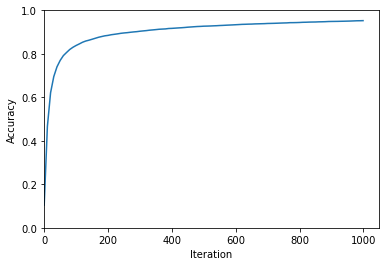

In [238]:
x,y=zip(*debug)
plt.plot(x,y)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
ax = plt.gca()
ax.set_xlim([0, None])
ax.set_ylim([0, 1])
print("Final accuracy: ",y[-1])

In [255]:
_,_,_,A2=forward_prop(W1,b1,W2,b2,data)
predictions=get_predictions(A2)
correct=labels==predictions
print(np.sum(~correct))
print("ID\tLabel\tPrediction\tError")
for i,(lab,pred,right) in enumerate(zip(*(labels,predictions,correct))):
    if not right:
        print(f"{i}\t{lab}\t\t{pred}\t {'x' if not right else ''}")


472
ID	Label	Prediction	Error
8	5		6	 x
33	4		6	 x
73	9		7	 x
124	7		4	 x
149	2		4	 x
195	3		5	 x
217	6		5	 x
227	4		9	 x
241	9		8	 x
245	3		5	 x
259	6		0	 x
274	9		7	 x
313	3		5	 x
320	9		1	 x
321	2		7	 x
341	6		4	 x
349	3		7	 x
381	3		7	 x
417	9		7	 x
428	4		9	 x
445	6		0	 x
448	9		8	 x
456	2		1	 x
478	5		8	 x
479	9		3	 x
495	8		0	 x
502	5		3	 x
507	3		8	 x
511	4		7	 x
515	3		2	 x
530	9		4	 x
543	8		3	 x
551	7		3	 x
552	0		9	 x
578	3		9	 x
591	8		3	 x
613	2		8	 x
619	1		8	 x
628	3		9	 x
629	2		6	 x
658	7		4	 x
659	2		9	 x
661	0		3	 x
664	8		5	 x
691	8		4	 x
707	4		9	 x
717	0		9	 x
720	5		8	 x
740	4		9	 x
760	4		9	 x
800	8		9	 x
866	5		8	 x
890	3		5	 x
900	1		3	 x
947	8		9	 x
965	6		0	 x
975	2		3	 x
999	9		7	 x
1014	6		5	 x
1032	5		8	 x
1039	7		1	 x
1044	6		8	 x
1062	3		7	 x
1096	7		9	 x
1107	9		3	 x
1114	3		8	 x
1173	7		9	 x
1181	6		1	 x
1182	6		8	 x
1192	9		4	 x
1224	2		6	 x
1226	7		2	 x
1232	9		4	 x
1242	4		9	 x
1247	9		0	 x
1251	2		0	 x
1260	7		1	 x
1270	4		9	 x
1274	4		7	 x
1283	

Label: 5	Prediction: 8


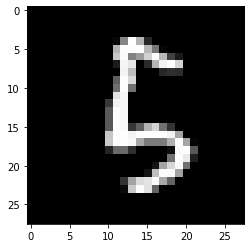

In [256]:
n=478
plt.imshow(data[:,n].reshape(nrows,ncols), cmap='gray')
print(f"Label: {labels[n]}\tPrediction: {predictions[n]}")
plt.show()

# Pruebas varias de todo tipo

In [241]:
a=np.arange(0,4)
b=np.arange(4)*2
print(a)
print(b)

[0 1 2 3]
[0 2 4 6]


In [242]:
a*b.T

array([ 0,  2,  8, 18])

In [243]:
np.atleast_2d(a).T.dot(np.atleast_2d(b))

array([[ 0,  0,  0,  0],
       [ 0,  2,  4,  6],
       [ 0,  4,  8, 12],
       [ 0,  6, 12, 18]])

In [244]:
a*np.atleast_2d(b).T

array([[ 0,  0,  0,  0],
       [ 0,  2,  4,  6],
       [ 0,  4,  8, 12],
       [ 0,  6, 12, 18]])

In [245]:
data.shape

(784, 10000)

In [246]:
x=data[:4,0:2]
x=np.arange(8).reshape((4,2))
x.shape

(4, 2)

In [247]:
x

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [248]:
dz1=one_hot_y[:,0:2]
dz1.shape

(10, 2)

In [249]:
dz1

array([[0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 0.]])

In [250]:
dwq=dz1.dot(x.T)
dwq.shape

(10, 4)

In [251]:
dwq

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 3., 5., 7.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 2., 4., 6.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [252]:
m=np.arange(9).reshape((3,3))
1*(m<5)

array([[1, 1, 1],
       [1, 1, 0],
       [0, 0, 0]])